# Prediction of Future Closing Stock Prices with Machine Learning v1.2

## Preliminaries: Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Part 1.1: Predict JFC stocks from 3/5/18 up to the present day then compare with latest      WSJ Data 

Since Google Finance data is not currently updated, we could get data from Wall Street Journal. Instead of using an API, we have to download csv files from the website.
Download csv file of JFC prices from 2013-1-1 up to the latest.

Source: http://quotes.wsj.com/PH/XPHS/JFC/historical-prices

Import data as a Pandas dataframe.

In [5]:
stock = pd.read_csv('JFC_WSJ.csv')

Inspect dataframe.

In [6]:
stock.columns

Index(['Date', ' Open', ' High', ' Low', ' Close', ' Volume'], dtype='object')

## 1.2: Data Cleaning 

Remove spaces from column names by renaming them.

In [7]:
stock.rename(columns=lambda x: x.strip(), inplace=True)
stock.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

Inspect the data types of each column, then the first 5 and last 5 rows of the dataframe.

In [8]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1276 entries, 0 to 1275
Data columns (total 6 columns):
Date      1276 non-null object
Open      1276 non-null float64
High      1276 non-null float64
Low       1276 non-null float64
Close     1276 non-null float64
Volume    1276 non-null int64
dtypes: float64(4), int64(1), object(1)
memory usage: 59.9+ KB


In [9]:
stock.head()

Date   Open   High    Low  Close  Volume
0  03/28/18  295.0  299.0  292.0  299.0  759390
1  03/27/18  295.0  297.0  289.4  294.4  356420
2  03/26/18  286.6  295.0  282.0  295.0  404650
3  03/23/18  285.0  288.0  280.0  288.0  864870
4  03/22/18  285.4  288.0  282.4  286.8  573890

In [10]:
stock.tail()

Date   Open   High    Low  Close  Volume
1271  01/08/13  107.1  107.7  107.1  107.3  389530
1272  01/07/13  107.5  107.5  106.7  107.0  719780
1273  01/04/13  107.0  107.6  107.0  107.6  548040
1274  01/03/13  104.8  107.5  104.8  107.2  684290
1275  01/02/13  102.0  104.5  102.0  104.2  125900

Find nan values. Replace them with -999999 if there are present.

In [11]:
stock.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

No NaN values!!!
However, we have to rearrange the data from descending to ascending order.

In [12]:
stock = stock.reindex(index=stock.index[::-1]).reset_index(drop=True)

In [13]:
stock.head()

Date   Open   High    Low  Close  Volume
0  01/02/13  102.0  104.5  102.0  104.2  125900
1  01/03/13  104.8  107.5  104.8  107.2  684290
2  01/04/13  107.0  107.6  107.0  107.6  548040
3  01/07/13  107.5  107.5  106.7  107.0  719780
4  01/08/13  107.1  107.7  107.1  107.3  389530

In [14]:
stock.tail()

Date   Open   High    Low  Close  Volume
1271  03/22/18  285.4  288.0  282.4  286.8  573890
1272  03/23/18  285.0  288.0  280.0  288.0  864870
1273  03/26/18  286.6  295.0  282.0  295.0  404650
1274  03/27/18  295.0  297.0  289.4  294.4  356420
1275  03/28/18  295.0  299.0  292.0  299.0  759390

Convert 'Date' column as datetime objects and set it as index column.

In [15]:
stock['Date'] = pd.to_datetime(stock['Date'], infer_datetime_format=True)

In [16]:
stock.set_index('Date',inplace=True)

In [17]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1276 entries, 2013-01-02 to 2018-03-28
Data columns (total 5 columns):
Open      1276 non-null float64
High      1276 non-null float64
Low       1276 non-null float64
Close     1276 non-null float64
Volume    1276 non-null int64
dtypes: float64(4), int64(1)
memory usage: 59.8 KB


In [18]:
type(stock.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [19]:
stock.tail()

Open   High    Low  Close  Volume
Date                                          
2018-03-22  285.4  288.0  282.4  286.8  573890
2018-03-23  285.0  288.0  280.0  288.0  864870
2018-03-26  286.6  295.0  282.0  295.0  404650
2018-03-27  295.0  297.0  289.4  294.4  356420
2018-03-28  295.0  299.0  292.0  299.0  759390

Create Copy for exercise.

In [20]:
stockC = stock.copy(deep=True)
stockC.tail(10)

Open   High    Low  Close   Volume
Date                                           
2018-03-15  288.4  288.6  282.6  284.0  1140780
2018-03-16  286.8  305.4  286.8  305.4  2052470
2018-03-19  299.6  299.6  295.2  298.0   531280
2018-03-20  296.8  296.8  285.0  286.0  1028940
2018-03-21  286.6  293.0  285.0  285.0   953100
2018-03-22  285.4  288.0  282.4  286.8   573890
2018-03-23  285.0  288.0  280.0  288.0   864870
2018-03-26  286.6  295.0  282.0  295.0   404650
2018-03-27  295.0  297.0  289.4  294.4   356420
2018-03-28  295.0  299.0  292.0  299.0   759390

Notice that there are no values for 03-03 and 03-04. Trading days exclude weekends and holidays.

Add Prediction column which contains the predicted Close column value n trading days later.

We'll try to predict the 'Close' values from 03-05 up to the latest day available.

In [21]:
day_start = stockC.index.get_loc(pd.Timestamp('2018-03-05'))
day_start

1258

In [22]:
day_end = len(stockC.index)
day_end

1276

In [23]:
n = day_end-day_start
n

18

We'll add a 'Prediction column' that contains the actual closing values n days later.

In [24]:
stockC['Prediction'] = stockC['Close'].shift(-n)
stockC.tail(n+1)

Open   High    Low  Close   Volume  Prediction
Date                                                       
2018-03-02  297.6  298.4  295.0  298.0   735080       299.0
2018-03-05  299.0  300.0  296.0  299.6   388840         NaN
2018-03-06  300.0  304.0  297.8  298.6   833460         NaN
2018-03-07  300.0  304.0  299.8  304.0   853340         NaN
2018-03-08  303.0  304.0  295.0  295.0   367970         NaN
2018-03-09  297.0  297.0  292.0  292.0   352590         NaN
2018-03-12  296.0  299.0  292.2  295.4   303520         NaN
2018-03-13  296.0  297.0  292.4  293.0   557650         NaN
2018-03-14  293.0  294.4  287.4  288.4   757340         NaN
2018-03-15  288.4  288.6  282.6  284.0  1140780         NaN
2018-03-16  286.8  305.4  286.8  305.4  2052470         NaN
2018-03-19  299.6  299.6  295.2  298.0   531280         NaN
2018-03-20  296.8  296.8  285.0  286.0  1028940         NaN
2018-03-21  286.6  293.0  285.0  285.0   953100         NaN
2018-03-22  285.4  288.0  282.4  286.8   573890         NaN
2018-03-23  285.0  288.0  280.0  288.0   864870         NaN
2018-03-26  286.6  295.0  282.0  295.0   404650         NaN
2018-03-27  295.0  297.0  289.4  294.4   356420         NaN
2018-03-28  295.0  299.0  292.0  299.0   759390         NaN

Notice that...

The predicted value in 2018-03-02, 299.0,

In [25]:
stockC['Prediction'].index[-n-1]

Timestamp('2018-03-02 00:00:00')

In [26]:
stockC['Prediction'][stockC['Prediction'].index[-n-1]]

299.0

Is the same as the closing price in 2018-03-28.

In [27]:
stockC['Close'].index[-1]

Timestamp('2018-03-28 00:00:00')

In [28]:
stockC['Close'][stockC['Close'].index[-1]]

299.0

## 1.3: Preprocessing 

The dataset would be divided as X and y; with X as... and y as...

In order to prepare the data for machine learning, we have to preprocess the X in order to...

In [29]:
from sklearn import preprocessing

In [30]:
X = preprocessing.scale(stockC.drop(['Prediction'], axis=1))

X would be split into two..;X would be the data before...

X_predict would be the data after... and would be used later to predict the future closing values.

In [31]:
X_predict = X[-n:]
X = X[:-n]

In [32]:
y = stockC['Prediction'][:-n]

In [33]:
print(type(X), type(X_predict), type(y))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'pandas.core.series.Series'>


In [34]:
print(len(X), len(X_predict), len(y))

1258 18 1258


## 1.4: Train Test Split 

Both X and y would be split into two; train set and test set. 

Train set would be used to train the computer while the test set would be used to compare and evaluate the predictions of the computer.

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(0.2))

In [37]:
print(type(X_train), type(X_test), type(y_train), type(y_test) )

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [38]:
print(len(X_train), len(X_test), len(y_train), len(y_test) )

1006 252 1006 252


## 1.5: Try with Linear Regression 

In [39]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [40]:
accuracy = lm.score(X_test, y_test)
print('Accuracy: '+str(accuracy*100)+'%')

Accuracy: 92.51210167611418%


## 1.6:  Cross Validation

In [41]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR

lm = SVR(kernel='linear', C=1)
scores = cross_val_score(lm, X, y, cv=5)
scores #score for each split

array([0.84249793, 0.79381486, 0.10125906, 0.56567935, 0.75841763])

In [42]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.61 (+/- 0.54)


## 1.7: Linear Regression after Cross Validation 

In [43]:
lm.fit(X_train, y_train)
accuracy = lm.score(X_test, y_test)
print('Accuracy: '+str(accuracy*100)+'%')

Accuracy: 92.47493425371538%


Text(0,0.5,'Predicted Y')

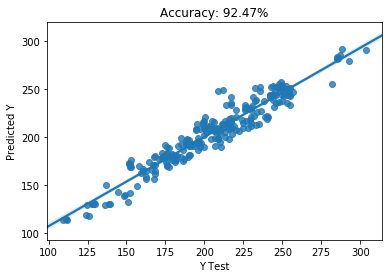

In [44]:
predictions = lm.predict(X_test)
sns.regplot(y_test,predictions)
plt.title('Accuracy: '+str((accuracy*100).round(2))+'%')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

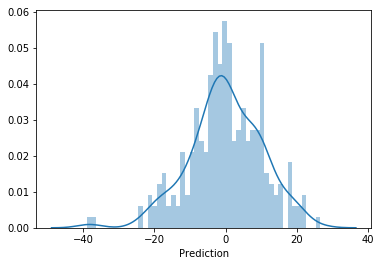

In [45]:
sns.distplot((y_test-predictions),bins=50)

## 1.8: Try with all regressors

C:\Users\LLagman\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


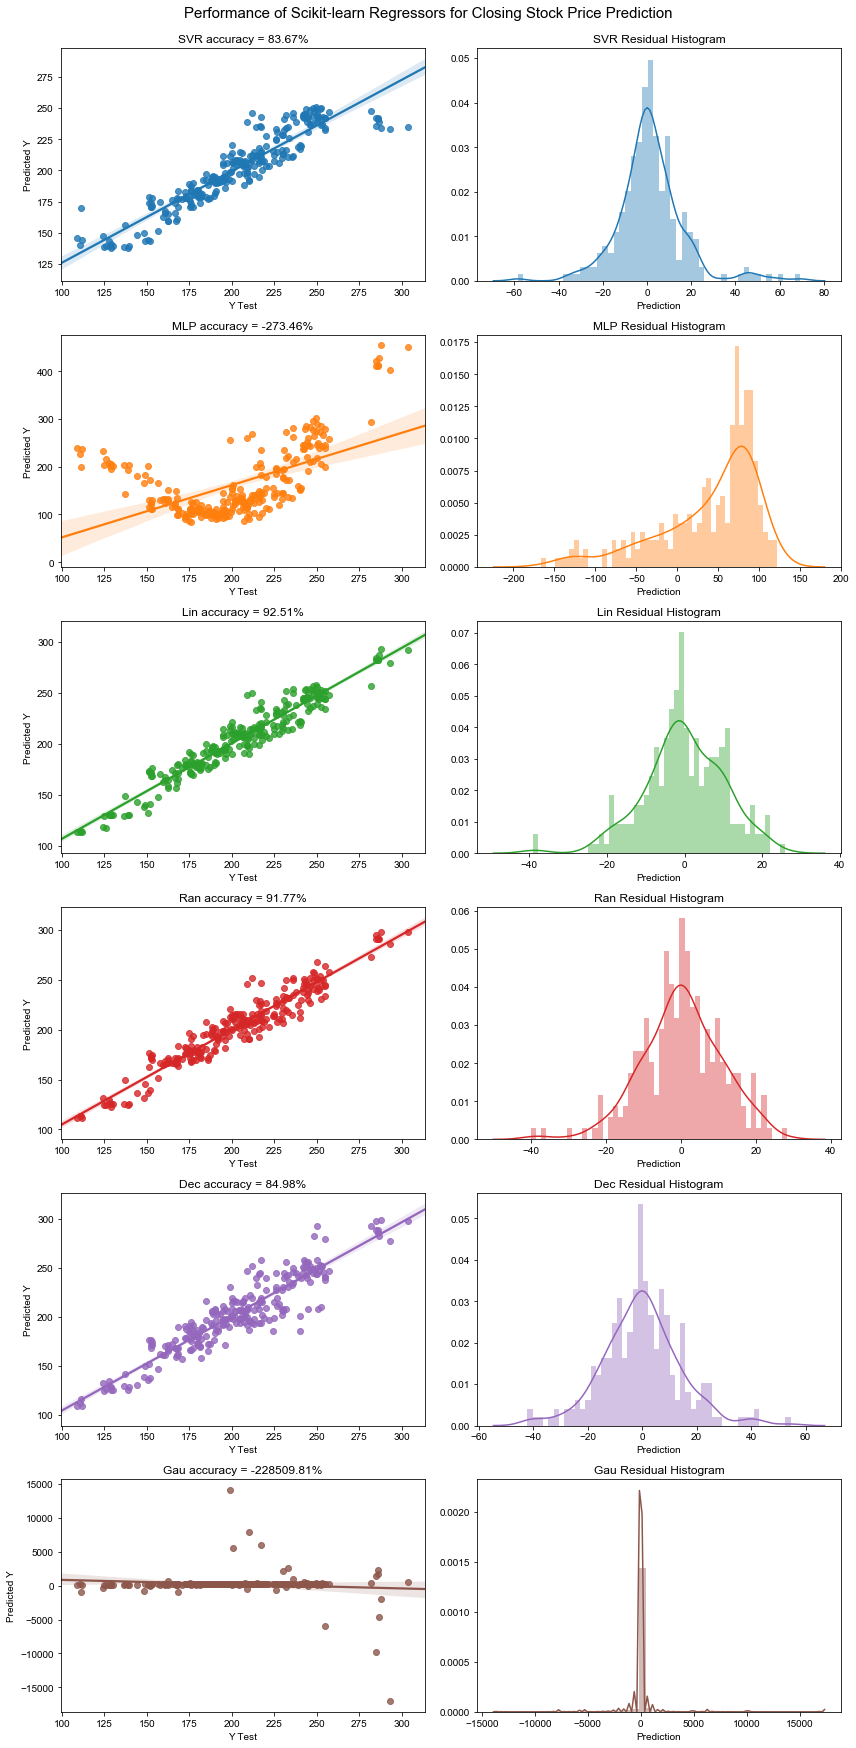

In [46]:
from sklearn import preprocessing#, cross_validation
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor as NNR
from sklearn.linear_model import LinearRegression as LRR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.gaussian_process import GaussianProcessRegressor as GPR

predictors = [SVR(), NNR(), LRR(), RFR(), DTR(), GPR()]

forecast = []
pred_cols = []
accuracy = []

fig, ax = plt.subplots(6,2, figsize=(12,24))

for pred, color, i in zip(predictors, sns.color_palette(), range(len(predictors))):
    pred.fit(X_train, y_train)
    accu = pred.score(X_test,y_test)
    predictions = pred.predict(X_test)
            
    sns.regplot(y_test,predictions, color=color, ax=ax[i,0])
    ax[i,0].set_title('{0} accuracy = {1:.2f}'.format(str(pred)[:3], (accu*100).round(2))+'%')
    ax[i,0].set_xlabel('Y Test')
    ax[i,0].set_ylabel('Predicted Y')
    
    sns.distplot((y_test-predictions), bins=50, color=color, ax=ax[i,1])
    ax[i,1].set_title('{0} Residual Histogram'.format(str(pred)[:3]))
    
    forecast.append(pred.predict(X_predict))
    pred_cols.append(str(pred)[:3])
    accuracy.append('{0} accuracy = {1:.2f}'.format(str(pred)[:3], (accu*100).round(2))+'%')
    
fig.suptitle('Performance of Scikit-learn Regressors for Closing Stock Price Prediction', fontsize=15, y=1.01)
sns.set_style('whitegrid')
fig.tight_layout()

##  1.9: Add forecast columns per regressor

Forecast: Data for columns

In [47]:
np.array(forecast).shape

(6, 18)

In [48]:
np.array(forecast)

array([[   226.64131159,    227.9322414 ,    226.25963377,
           225.72926565,    229.29615615,    227.64272656,
           231.89367427,    236.0680944 ,    236.93278162,
           210.03222093,    228.72333272,    233.93716431,
           238.11815347,    239.36019832,    240.46643231,
           233.71636485,    229.84720101,    231.40262232],
       [   472.72938483,    482.89924889,    490.80433296,
           475.07223187,    455.0618655 ,    459.39912342,
           457.36846381,    443.34028662,    426.40767498,
           477.40650445,    471.75929765,    447.34939739,
           430.91167186,    420.09754786,    421.12458817,
           435.24520125,    452.79466909,    466.12024662],
       [   297.3871654 ,    298.78273491,    301.42417808,
           296.54156815,    292.59865112,    293.94475253,
           293.18839029,    289.45065895,    285.41418701,
           297.73199129,    296.80818194,    289.21753555,
           286.42045605,    285.03661488,    285.14589

In [49]:
forecast_T = np.array(forecast).transpose()
forecast_T

array([[   226.64131159,    472.72938483,    297.3871654 ,
           296.3       ,    305.4       ,  -4297.67073941],
       [   227.9322414 ,    482.89924889,    298.78273491,
           294.58      ,    294.4       , -14670.46954668],
       [   226.25963377,    490.80433296,    301.42417808,
           294.58      ,    294.4       ,  -6435.35788274],
       [   225.72926565,    475.07223187,    296.54156815,
           289.28      ,    282.        ,   6517.16738629],
       [   229.29615615,    455.0618655 ,    292.59865112,
           289.28      ,    282.        ,  -2243.07315707],
       [   227.64272656,    459.39912342,    293.94475253,
           289.28      ,    282.        ,   4326.57942557],
       [   231.89367427,    457.36846381,    293.18839029,
           293.4       ,    298.6       ,   -880.00408185],
       [   236.0680944 ,    443.34028662,    289.45065895,
           297.72      ,    298.6       ,   -166.0376482 ],
       [   236.93278162,    426.40767498,    285

In [50]:
type(forecast_T)

numpy.ndarray

In [51]:
forecast_T.shape

(18, 6)

Days: Index

In [52]:
len(stockC.index)

1276

In [53]:
stockC.index[-1]

Timestamp('2018-03-28 00:00:00')

In [54]:
Days=stockC.index[-n:len(stockC.index)]
Days

DatetimeIndex(['2018-03-05', '2018-03-06', '2018-03-07', '2018-03-08',
               '2018-03-09', '2018-03-12', '2018-03-13', '2018-03-14',
               '2018-03-15', '2018-03-16', '2018-03-19', '2018-03-20',
               '2018-03-21', '2018-03-22', '2018-03-23', '2018-03-26',
               '2018-03-27', '2018-03-28'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [55]:
range(len(stockC.index[-n:len(stockC.index)]))

range(0, 18)

Accuracy: column names

In [56]:
type(accuracy)

list

In [57]:
accuracy

['SVR accuracy = 83.67%',
 'MLP accuracy = -273.46%',
 'Lin accuracy = 92.51%',
 'Ran accuracy = 91.77%',
 'Dec accuracy = 84.98%',
 'Gau accuracy = -228509.81%']

In [58]:
regs_stockC = pd.DataFrame(data=forecast_T,
                    index=stockC.index[-n:len(stockC.index)],
                    columns=accuracy)
regs_stockC

SVR accuracy = 83.67%  MLP accuracy = -273.46%  \
Date                                                         
2018-03-05             226.641312               472.729385   
2018-03-06             227.932241               482.899249   
2018-03-07             226.259634               490.804333   
2018-03-08             225.729266               475.072232   
2018-03-09             229.296156               455.061865   
2018-03-12             227.642727               459.399123   
2018-03-13             231.893674               457.368464   
2018-03-14             236.068094               443.340287   
2018-03-15             236.932782               426.407675   
2018-03-16             210.032221               477.406504   
2018-03-19             228.723333               471.759298   
2018-03-20             233.937164               447.349397   
2018-03-21             238.118153               430.911672   
2018-03-22             239.360198               420.097548   
2018-03-23             240.466432               421.124588   
2018-03-26             233.716365               435.245201   
2018-03-27             229.847201               452.794669   
2018-03-28             231.402622               466.120247   

            Lin accuracy = 92.51%  Ran accuracy = 91.77%  \
Date                                                       
2018-03-05             297.387165                 296.30   
2018-03-06             298.782735                 294.58   
2018-03-07             301.424178                 294.58   
2018-03-08             296.541568                 289.28   
2018-03-09             292.598651                 289.28   
2018-03-12             293.944753                 289.28   
2018-03-13             293.188390                 293.40   
2018-03-14             289.450659                 297.72   
2018-03-15             285.414187                 292.60   
2018-03-16             297.731991                 296.54   
2018-03-19             296.808182                 292.10   
2018-03-20             289.217536                 292.86   
2018-03-21             286.420456                 292.38   
2018-03-22             285.036615                 294.40   
2018-03-23             285.145894                 296.68   
2018-03-26             288.887924                 298.22   
2018-03-27             292.428489                 289.28   
2018-03-28             295.697519                 295.68   

            Dec accuracy = 84.98%  Gau accuracy = -228509.81%  
Date                                                           
2018-03-05                  305.4                -4297.670739  
2018-03-06                  294.4               -14670.469547  
2018-03-07                  294.4                -6435.357883  
2018-03-08                  282.0                 6517.167386  
2018-03-09                  282.0                -2243.073157  
2018-03-12                  282.0                 4326.579426  
2018-03-13                  298.6                 -880.004082  
2018-03-14                  298.6                 -166.037648  
2018-03-15                  292.0                -5789.842637  
2018-03-16                  295.0                20219.218317  
2018-03-19                  294.4                -3593.939510  
2018-03-20                  282.0               -25049.640894  
2018-03-21                  295.0                -3922.121591  
2018-03-22                  298.4                  -67.407902  
2018-03-23                  297.6                -3151.047740  
2018-03-26                  305.4                 3480.408737  
2018-03-27                  282.0                 -563.025846  
2018-03-28                  295.0                -1874.099003

In [59]:
accuracy

['SVR accuracy = 83.67%',
 'MLP accuracy = -273.46%',
 'Lin accuracy = 92.51%',
 'Ran accuracy = 91.77%',
 'Dec accuracy = 84.98%',
 'Gau accuracy = -228509.81%']

Actual Closing Price the trading day before the forecast.

In [60]:
print(stockC.index[-n-1])
print(stockC['Close'][-n-1])

2018-03-02 00:00:00
298.0


In [61]:
rowlink = []
for i in regs_stockC.columns:
    rowlink.append(stockC['Close'][-n-1])
np.array([rowlink])

array([[298., 298., 298., 298., 298., 298.]])

In [62]:
range(len(stockC.index[-n:len(stockC.index)]))

range(0, 18)

In [63]:
stockC.index[-n-1:len(stockC.index)]

DatetimeIndex(['2018-03-02', '2018-03-05', '2018-03-06', '2018-03-07',
               '2018-03-08', '2018-03-09', '2018-03-12', '2018-03-13',
               '2018-03-14', '2018-03-15', '2018-03-16', '2018-03-19',
               '2018-03-20', '2018-03-21', '2018-03-22', '2018-03-23',
               '2018-03-26', '2018-03-27', '2018-03-28'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [64]:
accuracy

['SVR accuracy = 83.67%',
 'MLP accuracy = -273.46%',
 'Lin accuracy = 92.51%',
 'Ran accuracy = 91.77%',
 'Dec accuracy = 84.98%',
 'Gau accuracy = -228509.81%']

In [65]:
stockC.index[-n-1:-n]

DatetimeIndex(['2018-03-02'], dtype='datetime64[ns]', name='Date', freq=None)

In [66]:
link = pd.DataFrame(data=np.array([rowlink]), 
                    index=stockC.index[-n-1:-n],
                    columns=accuracy)
link

SVR accuracy = 83.67%  MLP accuracy = -273.46%  \
Date                                                         
2018-03-02                  298.0                    298.0   

            Lin accuracy = 92.51%  Ran accuracy = 91.77%  \
Date                                                       
2018-03-02                  298.0                  298.0   

            Dec accuracy = 84.98%  Gau accuracy = -228509.81%  
Date                                                           
2018-03-02                  298.0                       298.0

# Merge the dataframes

In [67]:
predic_stockC = pd.merge(link,regs_stockC, how='outer').set_index(stockC.index[-n-1:len(stockC.index)])
predic_stockC

SVR accuracy = 83.67%  MLP accuracy = -273.46%  \
Date                                                         
2018-03-02             298.000000               298.000000   
2018-03-05             226.641312               472.729385   
2018-03-06             227.932241               482.899249   
2018-03-07             226.259634               490.804333   
2018-03-08             225.729266               475.072232   
2018-03-09             229.296156               455.061865   
2018-03-12             227.642727               459.399123   
2018-03-13             231.893674               457.368464   
2018-03-14             236.068094               443.340287   
2018-03-15             236.932782               426.407675   
2018-03-16             210.032221               477.406504   
2018-03-19             228.723333               471.759298   
2018-03-20             233.937164               447.349397   
2018-03-21             238.118153               430.911672   
2018-03-22             239.360198               420.097548   
2018-03-23             240.466432               421.124588   
2018-03-26             233.716365               435.245201   
2018-03-27             229.847201               452.794669   
2018-03-28             231.402622               466.120247   

            Lin accuracy = 92.51%  Ran accuracy = 91.77%  \
Date                                                       
2018-03-02             298.000000                 298.00   
2018-03-05             297.387165                 296.30   
2018-03-06             298.782735                 294.58   
2018-03-07             301.424178                 294.58   
2018-03-08             296.541568                 289.28   
2018-03-09             292.598651                 289.28   
2018-03-12             293.944753                 289.28   
2018-03-13             293.188390                 293.40   
2018-03-14             289.450659                 297.72   
2018-03-15             285.414187                 292.60   
2018-03-16             297.731991                 296.54   
2018-03-19             296.808182                 292.10   
2018-03-20             289.217536                 292.86   
2018-03-21             286.420456                 292.38   
2018-03-22             285.036615                 294.40   
2018-03-23             285.145894                 296.68   
2018-03-26             288.887924                 298.22   
2018-03-27             292.428489                 289.28   
2018-03-28             295.697519                 295.68   

            Dec accuracy = 84.98%  Gau accuracy = -228509.81%  
Date                                                           
2018-03-02                  298.0                  298.000000  
2018-03-05                  305.4                -4297.670739  
2018-03-06                  294.4               -14670.469547  
2018-03-07                  294.4                -6435.357883  
2018-03-08                  282.0                 6517.167386  
2018-03-09                  282.0                -2243.073157  
2018-03-12                  282.0                 4326.579426  
2018-03-13                  298.6                 -880.004082  
2018-03-14                  298.6                 -166.037648  
2018-03-15                  292.0                -5789.842637  
2018-03-16                  295.0                20219.218317  
2018-03-19                  294.4                -3593.939510  
2018-03-20                  282.0               -25049.640894  
2018-03-21                  295.0                -3922.121591  
2018-03-22                  298.4                  -67.407902  
2018-03-23                  297.6                -3151.047740  
2018-03-26                  305.4                 3480.408737  
2018-03-27                  282.0                 -563.025846  
2018-03-28                  295.0                -1874.099003

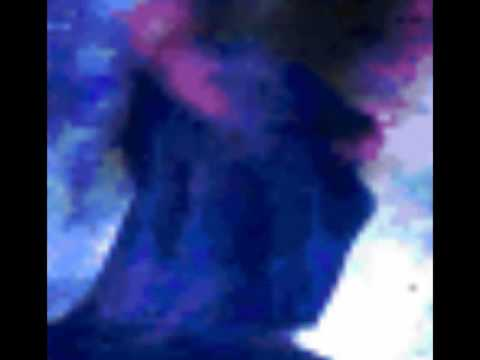

In [68]:
from IPython.display import YouTubeVideo
from datetime import timedelta

start=int(timedelta(seconds=10).total_seconds())
end=int(timedelta(seconds=14).total_seconds())

YouTubeVideo("VA41XQMUi-4", start=start, end=end, autoplay=1)

## 1.9.1: Plot all Regressor Predictions 

In [69]:
label='JFC.PH'

Text(0,0.5,'Closing Price (₱)\n')

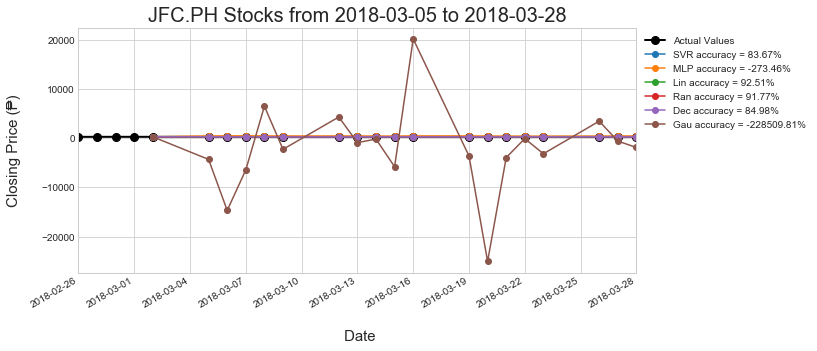

In [70]:
ax = stockC['Close'].plot(color='black', label='Actual Values', figsize=(10,5), lw=2,marker='o', markersize=8)
predic_stockC.plot(color=sns.color_palette(),marker='o', ax=ax)

plt.title('{0} Stocks from {1} to {2}'.format(label,str(predic_stockC.index[1])[0:10],str(predic_stockC.index[-1])[0:10]), fontsize=20)
plt.legend(loc='best',bbox_to_anchor=(1, 1))
plt.xlim(xmin=stockC.index[-n-5],xmax=stockC.index[-1])
plt.xlabel('\n Date', fontsize=15)
plt.ylabel('Closing Price (₱)\n', fontsize=15) 

In [71]:
predic_stockC.columns[0:-1].tolist()

['SVR accuracy = 83.67%',
 'MLP accuracy = -273.46%',
 'Lin accuracy = 92.51%',
 'Ran accuracy = 91.77%',
 'Dec accuracy = 84.98%']

In [72]:
sns.color_palette()[0:-1]

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)]

Text(0,0.5,'Closing Price (₱)\n')

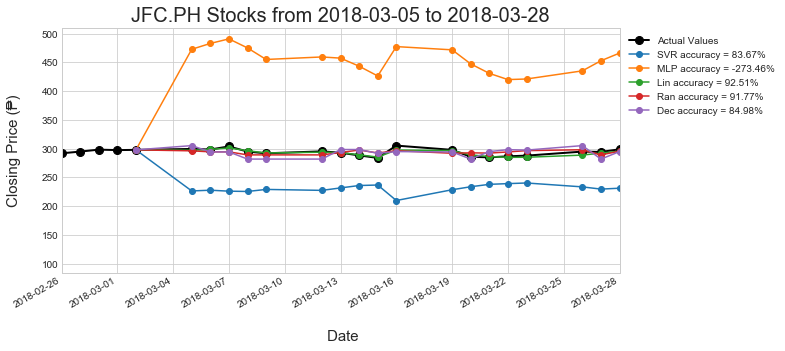

In [73]:
ax = stockC['Close'].plot(color='black', label='Actual Values', figsize=(10,5), lw=2, marker='o', markersize=8)
predic_stockC[predic_stockC.columns[0:-1].tolist()].plot(color=sns.color_palette()[0:-1], ax=ax, marker='o')

plt.title('{0} Stocks from {1} to {2}'.format(label,str(predic_stockC.index[1])[0:10],str(predic_stockC.index[-1])[0:10]), fontsize=20)
plt.legend(loc='best',bbox_to_anchor=(1, 1))
plt.xlim(xmin=stockC.index[-n-5],xmax=stockC.index[-1])
plt.xlabel('\n Date', fontsize=15)
plt.ylabel('Closing Price (₱)\n', fontsize=15) 

Plot every column in regs_stockC except MLP

In [74]:
predic_stockC.columns[1]

'MLP accuracy = -273.46%'

In [75]:
predic_stockC.columns[2:-1]

Index(['Lin accuracy = 92.51%', 'Ran accuracy = 91.77%',
       'Dec accuracy = 84.98%'],
      dtype='object')

In [76]:
predic_stockC.columns[2:-1]

Index(['Lin accuracy = 92.51%', 'Ran accuracy = 91.77%',
       'Dec accuracy = 84.98%'],
      dtype='object')

In [77]:
[predic_stockC.columns[0]]

['SVR accuracy = 83.67%']

In [78]:
[predic_stockC.columns[0]]+predic_stockC.columns[2:5].tolist()

['SVR accuracy = 83.67%',
 'Lin accuracy = 92.51%',
 'Ran accuracy = 91.77%',
 'Dec accuracy = 84.98%']

In [79]:
[sns.color_palette()[0]]+sns.color_palette()[2:5]

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353)]

Text(0,0.5,'Closing Price (₱)\n')

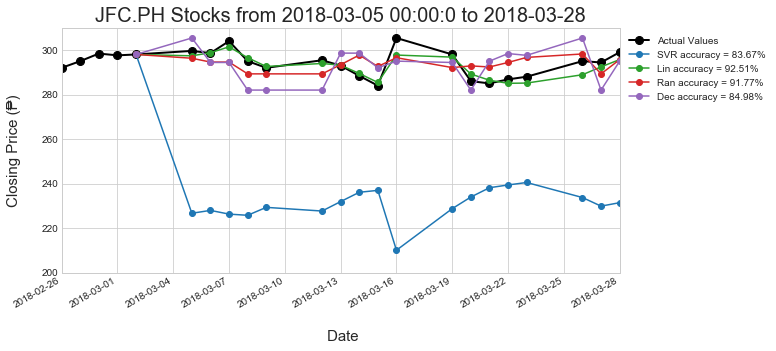

In [80]:
ax = stockC['Close'].plot(color='black', label='Actual Values', figsize=(10,5), lw=2, marker='o', markersize=8)
predic_stockC[[predic_stockC.columns[0]]+predic_stockC.columns[2:5].tolist()].plot(
    color=[sns.color_palette()[0]]+sns.color_palette()[2:5], ax=ax, marker='o')

plt.title('{0} Stocks from {1} to {2}'.format(label,str(predic_stockC.index[1])[0:n],str(predic_stockC.index[-1])[0:10]), fontsize=20)
plt.legend(loc='best',bbox_to_anchor=(1, 1))
plt.xlim(xmin=stockC.index[-n-5],xmax=stockC.index[-1])
plt.ylim(ymin=200, ymax=310)
plt.xlabel('\n Date', fontsize=15)
plt.ylabel('Closing Price (₱)\n', fontsize=15) 

## 1.9.2: Plot Lin, Ran, Dec forecasts with Plotly 

In [81]:
pl_predic_stockC = pd.concat([stockC['Close'],predic_stockC],axis=1)
pl_predic_stockC.rename(columns={'Close': 'Actual Closing Prices'}, inplace=True)

In [82]:
pl_predic_stockC.columns

Index(['Actual Closing Prices', 'SVR accuracy = 83.67%',
       'MLP accuracy = -273.46%', 'Lin accuracy = 92.51%',
       'Ran accuracy = 91.77%', 'Dec accuracy = 84.98%',
       'Gau accuracy = -228509.81%'],
      dtype='object')

In [83]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [84]:
import cufflinks as cf

In [85]:
init_notebook_mode(connected=True)

In [86]:
cf.go_offline()

In [87]:
[pl_predic_stockC.columns[0]]

['Actual Closing Prices']

In [88]:
pl_predic_stockC.columns[3:-1]

Index(['Lin accuracy = 92.51%', 'Ran accuracy = 91.77%',
       'Dec accuracy = 84.98%'],
      dtype='object')

In [89]:
ideal_plots = [pl_predic_stockC.columns[0]]+pl_predic_stockC.columns[3:-1].tolist()
ideal_plots

['Actual Closing Prices',
 'Lin accuracy = 92.51%',
 'Ran accuracy = 91.77%',
 'Dec accuracy = 84.98%']

In [91]:
pl_predic_stockC[ideal_plots].iplot(mode='lines+markers', 
                                    title='{0} Stocks from {1} to {2}'.format(label, 
                                                                              str(pl_predic_stockC.index[-n])[0:10], 
                                                                              str(pl_predic_stockC.index[-1])[0:10]), 
                                    xTitle='\nDate', 
                                    yTitle='Closing Price (₱)\n')

# Part 1.2: Predict JFC stocks 10 days later

In [116]:
stock.tail()

Open   High    Low  Close  Volume  Prediction
Date                                                      
2018-03-22  285.4  288.0  282.4  286.8  573890         NaN
2018-03-23  285.0  288.0  280.0  288.0  864870         NaN
2018-03-26  286.6  295.0  282.0  295.0  404650         NaN
2018-03-27  295.0  297.0  289.4  294.4  356420         NaN
2018-03-28  295.0  299.0  292.0  299.0  759390         NaN

In [117]:
pred_n=10
stock['Prediction'] = stock['Close'].shift(-pred_n)
stock.tail(pred_n+1)

Open   High    Low  Close   Volume  Prediction
Date                                                       
2018-03-14  293.0  294.4  287.4  288.4   757340       299.0
2018-03-15  288.4  288.6  282.6  284.0  1140780         NaN
2018-03-16  286.8  305.4  286.8  305.4  2052470         NaN
2018-03-19  299.6  299.6  295.2  298.0   531280         NaN
2018-03-20  296.8  296.8  285.0  286.0  1028940         NaN
2018-03-21  286.6  293.0  285.0  285.0   953100         NaN
2018-03-22  285.4  288.0  282.4  286.8   573890         NaN
2018-03-23  285.0  288.0  280.0  288.0   864870         NaN
2018-03-26  286.6  295.0  282.0  295.0   404650         NaN
2018-03-27  295.0  297.0  289.4  294.4   356420         NaN
2018-03-28  295.0  299.0  292.0  299.0   759390         NaN

In [118]:
X = preprocessing.scale(stock.drop(['Prediction'], axis=1))

In [119]:
X_predict = X[-pred_n:]
X = X[:-pred_n]

In [120]:
y = stock['Prediction'][:pred_n]

C:\Users\LLagman\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



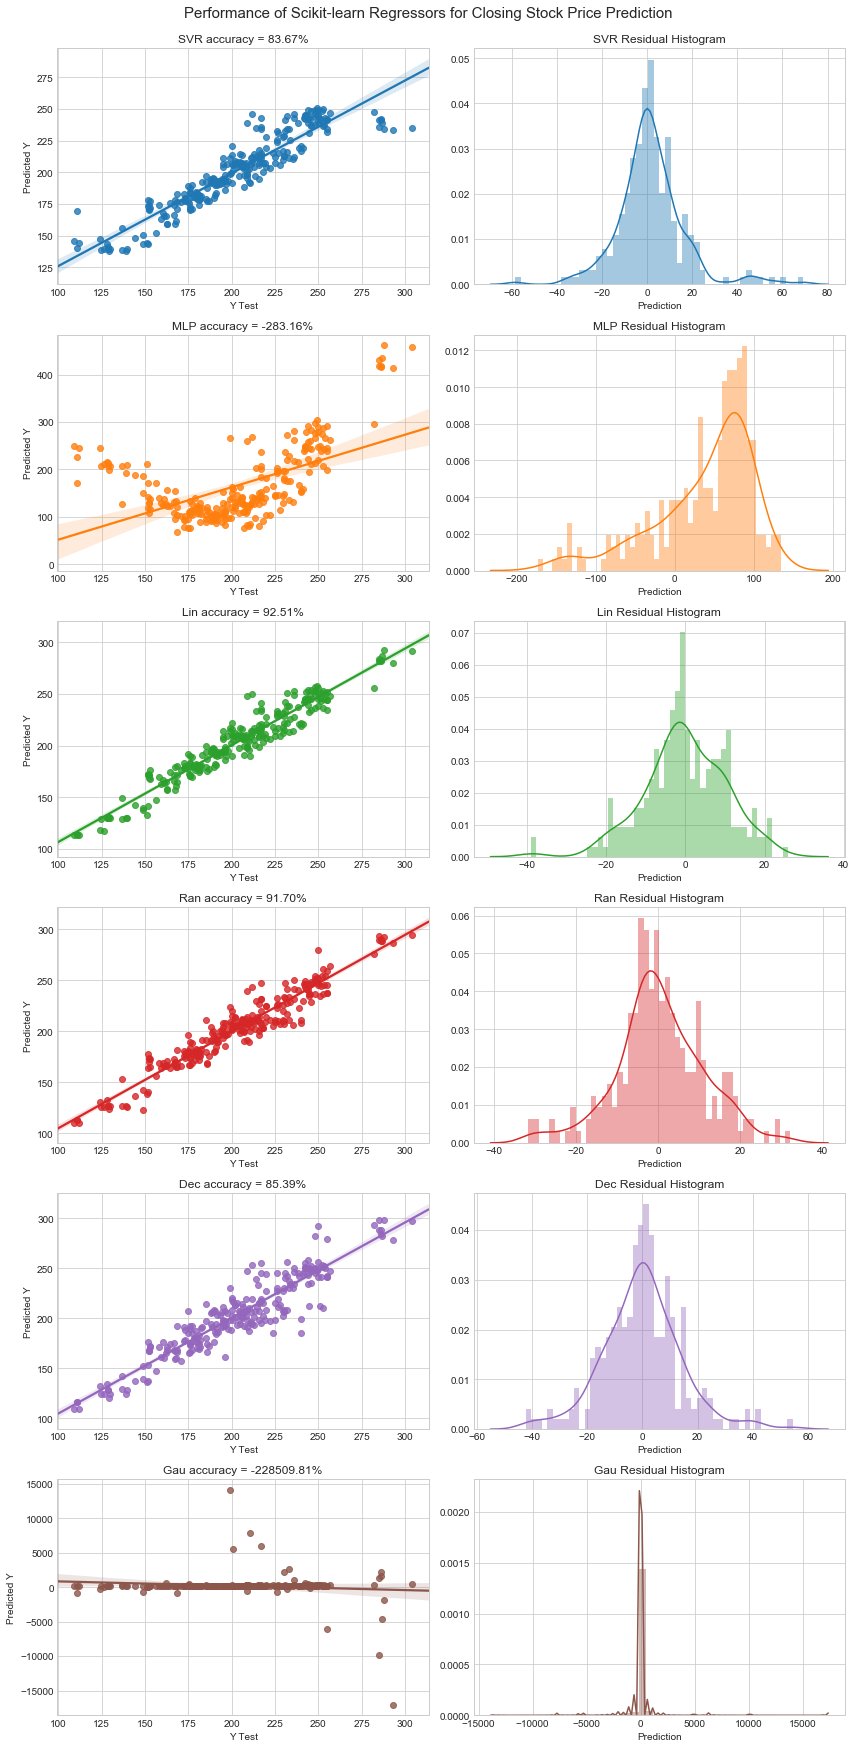

In [121]:
predictors = [SVR(), NNR(), LRR(), RFR(), DTR(), GPR()]

forecast = []
pred_cols = []
accuracy = []

fig, ax = plt.subplots(6,2, figsize=(12,24))

for pred, color, i in zip(predictors, sns.color_palette(), range(len(predictors))):
    pred.fit(X_train, y_train)
    accu = pred.score(X_test,y_test)
    predictions = pred.predict(X_test)
            
    sns.regplot(y_test,predictions, color=color, ax=ax[i,0])
    ax[i,0].set_title('{0} accuracy = {1:.2f}'.format(str(pred)[:3], (accu*100).round(2))+'%')
    ax[i,0].set_xlabel('Y Test')
    ax[i,0].set_ylabel('Predicted Y')
    
    sns.distplot((y_test-predictions), bins=50, color=color, ax=ax[i,1])
    ax[i,1].set_title('{0} Residual Histogram'.format(str(pred)[:3]))
    
    forecast.append(pred.predict(X_predict))
    pred_cols.append(str(pred)[:3])
    accuracy.append('{0} accuracy = {1:.2f}'.format(str(pred)[:3], (accu*100).round(2))+'%')
    
fig.suptitle('Performance of Scikit-learn Regressors for Closing Stock Price Prediction', fontsize=15, y=1.01)
sns.set_style('whitegrid')
fig.tight_layout()

In [122]:
np.array(forecast).shape

(6, 10)

In [123]:
np.array(forecast)

array([[   236.93278162,    210.03222093,    228.72333272,
           233.93716431,    238.11815347,    239.36019832,
           240.46643231,    233.71636485,    229.84720101,
           231.40262232],
       [   435.18103451,    495.98844269,    476.8816025 ,
           455.49419105,    438.43945002,    424.59654937,
           427.83716846,    438.83456614,    456.21994975,
           472.95420998],
       [   285.41418701,    297.73199129,    296.80818194,
           289.21753555,    286.42045605,    285.03661488,
           285.14589406,    288.88792356,    292.42848934,
           295.69751943],
       [   293.4       ,    294.46      ,    290.78      ,
           290.7       ,    290.8       ,    294.94      ,
           295.98      ,    299.2       ,    291.62      ,
           293.42      ],
       [   292.        ,    295.        ,    294.4       ,
           282.        ,    292.        ,    298.4       ,
           297.6       ,    305.4       ,    282.        ,
           

In [124]:
regs_forecast = np.array(forecast).transpose()
regs_forecast

array([[   236.93278162,    435.18103451,    285.41418701,
           293.4       ,    292.        ,  -5789.8426373 ],
       [   210.03222093,    495.98844269,    297.73199129,
           294.46      ,    295.        ,  20219.21831729],
       [   228.72333272,    476.8816025 ,    296.80818194,
           290.78      ,    294.4       ,  -3593.93950963],
       [   233.93716431,    455.49419105,    289.21753555,
           290.7       ,    282.        , -25049.64089417],
       [   238.11815347,    438.43945002,    286.42045605,
           290.8       ,    292.        ,  -3922.12159085],
       [   239.36019832,    424.59654937,    285.03661488,
           294.94      ,    298.4       ,    -67.40790176],
       [   240.46643231,    427.83716846,    285.14589406,
           295.98      ,    297.6       ,  -3151.04773998],
       [   233.71636485,    438.83456614,    288.88792356,
           299.2       ,    305.4       ,   3480.40873671],
       [   229.84720101,    456.21994975,    292

Create datetime index for n days that excludes weekends and holidays. 

Business days only, minus holidays.

In [125]:
last_day = stock.index[-1]
last_day

Timestamp('2018-03-28 00:00:00')

In [126]:
last_day = stock.index[-1].to_pydatetime()
last_day

datetime.datetime(2018, 3, 28, 0, 0)

In [127]:
holiday_dates=pd.DatetimeIndex([pd.to_datetime('2018-03-29'), pd.to_datetime('2018-03-30'), pd.to_datetime('2018-04-09')])
holiday_dates

DatetimeIndex(['2018-03-29', '2018-03-30', '2018-04-09'], dtype='datetime64[ns]', freq=None)

In [128]:
len(holiday_dates)

3

In [129]:
from datetime import datetime, timedelta

In [130]:
forecast_dates = (pd.bdate_range(last_day, periods=((pred_n+1)+len(holiday_dates)))).drop(holiday_dates)
forecast_dates

DatetimeIndex(['2018-03-28', '2018-04-02', '2018-04-03', '2018-04-04',
               '2018-04-05', '2018-04-06', '2018-04-10', '2018-04-11',
               '2018-04-12', '2018-04-13', '2018-04-16'],
              dtype='datetime64[ns]', freq=None)

In [131]:
accuracy

['SVR accuracy = 83.67%',
 'MLP accuracy = -283.16%',
 'Lin accuracy = 92.51%',
 'Ran accuracy = 91.70%',
 'Dec accuracy = 85.39%',
 'Gau accuracy = -228509.81%']

In [132]:
regs_stock = pd.DataFrame(data=regs_forecast,
                    index=forecast_dates[1:],
                    columns=accuracy)
regs_stock

SVR accuracy = 83.67%  MLP accuracy = -283.16%  \
2018-04-02             236.932782               435.181035   
2018-04-03             210.032221               495.988443   
2018-04-04             228.723333               476.881602   
2018-04-05             233.937164               455.494191   
2018-04-06             238.118153               438.439450   
2018-04-10             239.360198               424.596549   
2018-04-11             240.466432               427.837168   
2018-04-12             233.716365               438.834566   
2018-04-13             229.847201               456.219950   
2018-04-16             231.402622               472.954210   

            Lin accuracy = 92.51%  Ran accuracy = 91.70%  \
2018-04-02             285.414187                 293.40   
2018-04-03             297.731991                 294.46   
2018-04-04             296.808182                 290.78   
2018-04-05             289.217536                 290.70   
2018-04-06             286.420456                 290.80   
2018-04-10             285.036615                 294.94   
2018-04-11             285.145894                 295.98   
2018-04-12             288.887924                 299.20   
2018-04-13             292.428489                 291.62   
2018-04-16             295.697519                 293.42   

            Dec accuracy = 85.39%  Gau accuracy = -228509.81%  
2018-04-02                  292.0                -5789.842637  
2018-04-03                  295.0                20219.218317  
2018-04-04                  294.4                -3593.939510  
2018-04-05                  282.0               -25049.640894  
2018-04-06                  292.0                -3922.121591  
2018-04-10                  298.4                  -67.407902  
2018-04-11                  297.6                -3151.047740  
2018-04-12                  305.4                 3480.408737  
2018-04-13                  282.0                 -563.025846  
2018-04-16                  294.4                -1874.099003

Create forecast link dataframe

In [138]:
stock['Close'][-1:]

Date
2018-03-28    299.0
Name: Close, dtype: float64

In [139]:
forecast_rowlink = []
for i in regs_stock.columns:
    forecast_rowlink.append(stock['Close'][-1])
np.array([forecast_rowlink])

array([[299., 299., 299., 299., 299., 299.]])

In [140]:
forecast_link_stock = pd.DataFrame(data=np.array([forecast_rowlink]), 
                                   index=stock.index[-1:], 
                                   columns=accuracy)
forecast_link_stock

SVR accuracy = 83.67%  MLP accuracy = -283.16%  \
Date                                                         
2018-03-28                  299.0                    299.0   

            Lin accuracy = 92.51%  Ran accuracy = 91.70%  \
Date                                                       
2018-03-28                  299.0                  299.0   

            Dec accuracy = 85.39%  Gau accuracy = -228509.81%  
Date                                                           
2018-03-28                  299.0                       299.0

In [141]:
predic_stock = pd.merge(forecast_link_stock,regs_stock, how='outer').set_index(forecast_dates)
predic_stock

SVR accuracy = 83.67%  MLP accuracy = -283.16%  \
2018-03-28             299.000000               299.000000   
2018-04-02             236.932782               435.181035   
2018-04-03             210.032221               495.988443   
2018-04-04             228.723333               476.881602   
2018-04-05             233.937164               455.494191   
2018-04-06             238.118153               438.439450   
2018-04-10             239.360198               424.596549   
2018-04-11             240.466432               427.837168   
2018-04-12             233.716365               438.834566   
2018-04-13             229.847201               456.219950   
2018-04-16             231.402622               472.954210   

            Lin accuracy = 92.51%  Ran accuracy = 91.70%  \
2018-03-28             299.000000                 299.00   
2018-04-02             285.414187                 293.40   
2018-04-03             297.731991                 294.46   
2018-04-04             296.808182                 290.78   
2018-04-05             289.217536                 290.70   
2018-04-06             286.420456                 290.80   
2018-04-10             285.036615                 294.94   
2018-04-11             285.145894                 295.98   
2018-04-12             288.887924                 299.20   
2018-04-13             292.428489                 291.62   
2018-04-16             295.697519                 293.42   

            Dec accuracy = 85.39%  Gau accuracy = -228509.81%  
2018-03-28                  299.0                  299.000000  
2018-04-02                  292.0                -5789.842637  
2018-04-03                  295.0                20219.218317  
2018-04-04                  294.4                -3593.939510  
2018-04-05                  282.0               -25049.640894  
2018-04-06                  292.0                -3922.121591  
2018-04-10                  298.4                  -67.407902  
2018-04-11                  297.6                -3151.047740  
2018-04-12                  305.4                 3480.408737  
2018-04-13                  282.0                 -563.025846  
2018-04-16                  294.4                -1874.099003

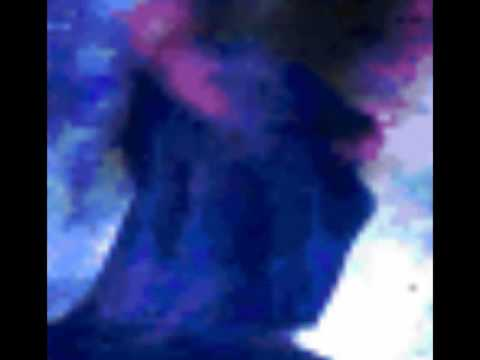

In [142]:
YouTubeVideo("VA41XQMUi-4", start=start, end=end, autoplay=1)

In [144]:
pl_predic_stock = pd.concat([stockC['Close'],predic_stock],axis=1)
pl_predic_stock.rename(columns={'Close': 'Actual Closing Prices'}, inplace=True)
pl_predic_stock

Actual Closing Prices  SVR accuracy = 83.67%  \
2013-01-02                  104.2                    NaN   
2013-01-03                  107.2                    NaN   
2013-01-04                  107.6                    NaN   
2013-01-07                  107.0                    NaN   
2013-01-08                  107.3                    NaN   
2013-01-09                  107.3                    NaN   
2013-01-10                  107.4                    NaN   
2013-01-11                  107.5                    NaN   
2013-01-14                  108.0                    NaN   
2013-01-15                  106.1                    NaN   
2013-01-16                  108.5                    NaN   
2013-01-17                  106.9                    NaN   
2013-01-18                  108.0                    NaN   
2013-01-21                  108.3                    NaN   
2013-01-22                  107.0                    NaN   
2013-01-23                  106.7                    NaN   
2013-01-24                  107.9                    NaN   
2013-01-25                  107.1                    NaN   
2013-01-28                  110.0                    NaN   
2013-01-29                  108.8                    NaN   
2013-01-30                  108.5                    NaN   
2013-01-31                  109.7                    NaN   
2013-02-01                  109.2                    NaN   
2013-02-04                  112.9                    NaN   
2013-02-05                  111.9                    NaN   
2013-02-06                  109.1                    NaN   
2013-02-07                  113.9                    NaN   
2013-02-08                  112.0                    NaN   
2013-02-11                  111.9                    NaN   
2013-02-12                  110.0                    NaN   
...                           ...                    ...   
2018-03-01                  297.6                    NaN   
2018-03-02                  298.0                    NaN   
2018-03-05                  299.6                    NaN   
2018-03-06                  298.6                    NaN   
2018-03-07                  304.0                    NaN   
2018-03-08                  295.0                    NaN   
2018-03-09                  292.0                    NaN   
2018-03-12                  295.4                    NaN   
2018-03-13                  293.0                    NaN   
2018-03-14                  288.4                    NaN   
2018-03-15                  284.0                    NaN   
2018-03-16                  305.4                    NaN   
2018-03-19                  298.0                    NaN   
2018-03-20                  286.0                    NaN   
2018-03-21                  285.0                    NaN   
2018-03-22                  286.8                    NaN   
2018-03-23                  288.0                    NaN   
2018-03-26                  295.0                    NaN   
2018-03-27                  294.4                    NaN   
2018-03-28                  299.0             299.000000   
2018-04-02                    NaN             236.932782   
2018-04-03                    NaN             210.032221   
2018-04-04                    NaN             228.723333   
2018-04-05                    NaN             233.937164   
2018-04-06                    NaN             238.118153   
2018-04-10                    NaN             239.360198   
2018-04-11                    NaN             240.466432   
2018-04-12                    NaN             233.716365   
2018-04-13                    NaN             229.847201   
2018-04-16                    NaN             231.402622   

            MLP accuracy = -283.16%  Lin accuracy = 92.51%  \
2013-01-02                      NaN                    NaN   
2013-01-03                      NaN                    NaN   
2013-01-04                      NaN                    NaN   
2013-01-07                      NaN        

In [145]:
ideal_plots = [pl_predic_stock.columns[0]]+pl_predic_stock.columns[3:-1].tolist()
ideal_plots

['Actual Closing Prices',
 'Lin accuracy = 92.51%',
 'Ran accuracy = 91.70%',
 'Dec accuracy = 85.39%']

In [146]:
pl_predic_stock[ideal_plots].iplot(mode='lines+markers', 
                                    title='{0} Predicted Closing Prices from {1} to {2}'.format(label, 
                                                                              str(pl_predic_stock.index[-pred_n])[0:10], 
                                                                              str(pl_predic_stock.index[-1])[0:10]), 
                                    xTitle='\nDate', 
                                    yTitle='Closing Price (₱)\n')